### Chess Hi-C analysis
This notebook documents the detection of structural changes during _Legionella_ infection of _Acanthamoeba castellanii_. We use [CHESS](https://github.com/vaquerizaslab/chess) to detect these changes

In [ ]:
import os
import re
from os.path import expanduser, join
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cooler
import pyranges as pr

In [1]:
warnings.filterwarnings('ignore')
home_dir = expanduser("~")
os.chdir(join(home_dir, 'Repos/Acastellanii_legionella_infection/'))
hic_samples = pd.read_csv('samples.tsv', sep='\t', comment='#')
RES = 2000
CTL = f'data/output/cool/sub_uninfected.mcool::/resolutions/{RES}'
INF = f'data/output/cool/sub_infected.mcool::/resolutions/{RES}'
clr_ctl = cooler.Cooler(CTL)
clr_inf = cooler.Cooler(INF)
WIN = 100000
STEP = 8000

First, I split the genome into overlapping sliding windows. Windows have a size of 100kb (50 bins) and the step size is 8kb (4 bins). I run chess on the control and infected maps to compute a similarity z-score (z-ssim) between conditions for each window.

In [2]:
%%bash -s "$WIN" "$STEP" "$CTL" "$INF"
# Setup dirs
mkdir chess
mkdir chess/features
# Generate chromsizes file
# fasta must be indexed !
# samtools faidx data/input/genome/C3.fa
cut -f1,2 data/input/genome/C3.fa.fai > chess/chrom.size
chess pairs chess/chrom.size "$1" "$2" "chess/$1_win_$2_step.bed"
chess sim "$3" "$4" "chess/$1_win_$2_step.bed" "chess/$1_win_$2_step_legio_results.tsv" -p6

b"ERROR 1064 (42000) at line 1: You have an error in your SQL syntax; check the manual that corresponds to your MariaDB server version for the right syntax to use near '/chrom.size.chromInfo' at line 1\n"
Commands were:

mysql --user=genome --host=genome-mysql.cse.ucsc.edu -A -e "select chrom, size from chess/chrom.size.chromInfo"
b'INFO: trying CURL  for database chess/chrom.size\nurl: http://hgdownload.soe.ucsc.edu/goldenPath/chess/chrom.size/bigZips/chess/chrom.size.chrom.sizes\n'
Commands were:

fetchChromSizes chess/chrom.size
mkdir: cannot create directory ‘chess’: File exists
mkdir: cannot create directory ‘chess/features’: File exists
2021-07-06 15:54:41,413 INFO Running '/home/cmatthey/anaconda3/envs/py37/bin/chess pairs chess/chrom.size 100000 8000 chess/100000_win_8000_step.bed'
2021-07-06 15:54:42,056 INFO CHESS version: 0.3.6
2021-07-06 15:54:42,056 INFO FAN-C version: 0.9.14
2021-07-06 15:54:45,205 INFO No entry found with pybedtools. Trying to read from file.
2021-07-06 

Now we need to filter windows of interest based on two features:
* SN: Signal to noise ratio
* z-ssim: Z-score of similarity

Interesting windows will have a good signal-to-noise ratio and a low similarity score (changes happening between conditions).

In [3]:
### Chess change detection
chess = pd.read_csv(f'chess/{WIN}_win_{STEP}_step_legio_results.tsv', sep='\t')
wins = pd.read_csv(f'chess/{WIN}_win_{STEP}_step.bed', sep='\t', header=None)
chess['start'] = wins.iloc[:, 1]
# Make start position absolute (not relative to chromosome)
chess['abs_start'] = chess['start'].diff().fillna(0)
chromstart = chess.abs_start < 0
chess.abs_start[chromstart] = 1
chess.abs_start = chess.abs_start.cumsum()
# Remember abs position of chromosome starts
chromstart = chess.abs_start[chromstart]

<IPython.core.display.Javascript object>


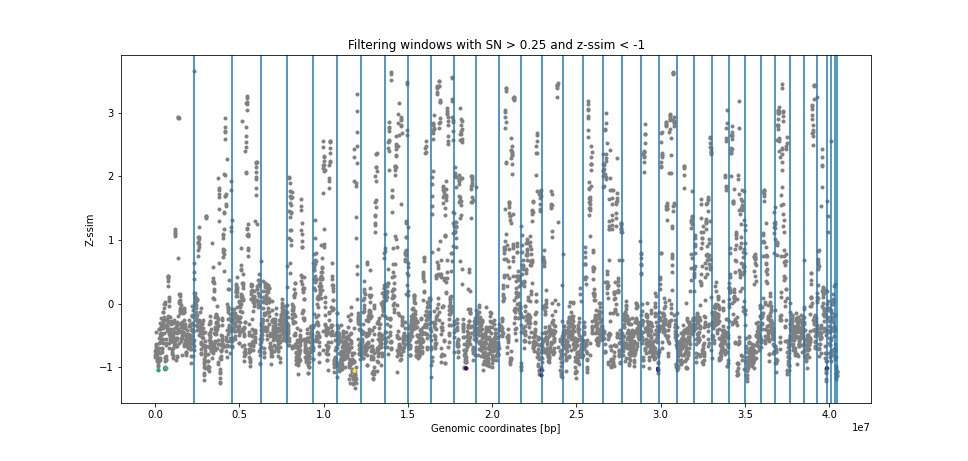

In [5]:
%matplotlib notebook
SN_THRESH = 0.25
ZSSIM_THRESH = -1
hits = (chess.SN > SN_THRESH) & (chess.z_ssim < ZSSIM_THRESH)
plt.scatter(chess.abs_start, chess.z_ssim, c='gray', marker='.')
plt.scatter(chess.abs_start[hits], chess.z_ssim[hits], c=chess.SN[hits], marker='.')
for v in chromstart.values:
    plt.axvline(v)
plt.xlabel("Genomic coordinates [bp]")
plt.ylabel("Z-ssim")
plt.title(f"Filtering windows with SN > {SN_THRESH} and z-ssim < {ZSSIM_THRESH}")
wins.loc[hits, :].to_csv(f'chess/{WIN}_win_{STEP}_step_filtered.bed', header=None, index=False, sep='\t')

I then use `chess extract` to extract differential features in those filtered windows, and `chess crosscorrelate` to cluster these features by similarity.

In [6]:
%%bash -s "$WIN" "$STEP" "$CTL" "$INF"
chess extract "chess/$1_win_$2_step_filtered.bed" "$3" "$4" chess/features
chess crosscorrelate chess/features/lost_features.tsv \
                     "chess/$1_win_$2_step_filtered.bed" \
                     ./chess/features

2021-07-06 16:42:39,328 INFO Running '/home/cmatthey/anaconda3/envs/py37/bin/chess extract chess/100000_win_8000_step_filtered.bed data/output/cool/sub_uninfected.mcool::/resolutions/2000 data/output/cool/sub_infected.mcool::/resolutions/2000 chess/features'
2021-07-06 16:42:39,955 INFO CHESS version: 0.3.6
2021-07-06 16:42:39,955 INFO FAN-C version: 0.9.14
2021-07-06 16:42:39,956 INFO Loading reference contact data
2021-07-06 16:43:07,496 INFO Loading region pairs
2021-07-06 16:43:07,496 INFO Applying image filtering to identify specific structures
2021-07-06 16:43:07,614 INFO Results collected
2021-07-06 16:43:07,700 INFO Finished '/home/cmatthey/anaconda3/envs/py37/bin/chess extract chess/100000_win_8000_step_filtered.bed data/output/cool/sub_uninfected.mcool::/resolutions/2000 data/output/cool/sub_infected.mcool::/resolutions/2000 chess/features'
2021-07-06 16:43:08,620 INFO Running '/home/cmatthey/anaconda3/envs/py37/bin/chess crosscorrelate chess/features/lost_features.tsv chess/

Now let's visualize the automatically extracted features.

In [6]:
import scipy.ndimage as ndi

# I made a PR to include these rotation functions in CHESS,
# if it is accepted, this code can be replaced by their API.

def rotate_feature(x, y, window_size, zoom_factor=1.0/0.7):
    """Rotate a single x,y coordinate within a region by -45 degrees.
    This allows conversion of coordinates from chess extract output to genomic bins.

    Parameters
    ----------
    x : int
        The x coordinate of a single point within the window, as found in the
        output of chess extract
    y : int
        The y coordinate of a single point within the window, as found in the
        output of chess extract.
    window_size : int
        The size of the window region.

    Returns
    -------
    x_r, y_r : tuple of int
        The rotated coordinates.
    """
    # NOTE: There will be some rounding errors when rotating the system. Not sure
    # what is the best way to handle them, for now I just round to the closest int.
    
    # Convert degree to radians
    theta = np.radians(-45)
    # Compute rotation matrix
    rot = np.array(
        [[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]]
    )
    # Get rotation center
    center = window_size / 2
    # Substract rotation center and rotate
    x_r, y_r = zoom_factor * rot @ np.array([x - center, y - center])
    # Add back rotation center
    x_r += center
    y_r += center
    return round(x_r), round(y_r)


def get_feature_coords(coords, win_size, win_bp_start, res):
    """Get basepair coordinates of a feature by rotating it and converting
    bins to coordinates

    Parameters
    ----------
    coords : tuple of int
        The coordinate of the feature within the window, as found in the
        output of chess extract: (xmin, xmax, ymin, ymax)
    win_size : int
        The size of the window region in bins.
    win_bp_start : int
        The start coordinate of the window in base pairs.
    res : int
        The resolution of the Hi-C matrix, i.e. the number of basepairs
        per bin.

    Returns
    -------
    x_coords, y_coords : tuple of lists of int
        The genomic coordinates of the feature on both axes, in
        the format: ([x_start, x_end], [y_start, y_end])
    """
    # Rotate input coordinates by 45 degrees to get genomic bins
    xmin, xmax, ymin, ymax = coords
    xmin_r, ymin_r = rotate_feature(ymin, ymin, win_size)
    xmin_r, ymax_r = rotate_feature(xmin, ymax, win_size)
    xmax_r, ymin_r = rotate_feature(xmin, ymin, win_size)


    # Generate new genomic coordinates
    x_coords = [xmin_r * res + win_bp_start, xmax_r * res + win_bp_start]
    y_coords = [ymin_r * res + win_bp_start, ymax_r * res + win_bp_start]

    return x_coords, y_coords


def clipped_zoom(img, zoom_factor, **kwargs):
    h, w = img.shape[:2]
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)
    if zoom_factor < 1:
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = ndi.zoom(img, zoom_tuple, **kwargs)
    elif zoom_factor > 1:
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2
        out = ndi.zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]
    else:
        out = img
    return out

In [20]:
%matplotlib notebook
from chromosight.utils.preprocessing import detrend
from matplotlib.patches import Rectangle
import serpentine as serp
import scipy.ndimage as ndi

# Load features
def load_chess_features(wins_path: str, feature_dir: str):
    """Loads chess features (gained and lost) into a clean dataframe"""
    
    chess_wins = pd.read_csv(wins_path,
        sep='\t',
        usecols=[0, 1, 2, 6],
        names=['chrom', 'start', 'end', 'win_id']
    )
    # Read lost and gained features and attach window information
    chess_gained = pd.read_csv(
        join(feature_dir, 'gained_features.tsv'),
        usecols=range(6),
        names=['win_id', 'ft_id', 'xmin', 'xmax', 'ymin', 'ymax']
    ).merge(chess_wins, on='win_id', how='inner')
    chess_lost = pd.read_csv(
        join(feature_dir, 'lost_features.tsv'),
        usecols=range(6),
        names=['win_id', 'ft_id', 'xmin', 'xmax', 'ymin', 'ymax']
    ).merge(chess_wins, on='win_id', how='inner')
    
    # Combine gained and lost features in a single table
    chess_gained['state'] = 'gained'
    chess_lost['state'] = 'lost'
    chess_features = (
        pd.concat([chess_gained, chess_lost])
        .drop_duplicates(['xmin', 'xmax'])
        .reset_index(drop=True)
    )
    
    return chess_features


chess_features = load_chess_features(f'chess/{WIN}_win_{STEP}_step_filtered.bed', 'chess/features/')
chess_features

,win_id,ft_id,xmin,xmax,ymin,ymax,chrom,start,end,state
0,74,0,40,42,20,31,scaffold_1,592001,692001,gained
1,74,1,29,30,22,29,scaffold_1,592001,692001,gained
2,75,2,38,39,22,29,scaffold_1,600001,700001,gained
3,2879,3,25,27,21,30,scaffold_15,1240001,1340001,gained
4,2880,4,21,23,21,30,scaffold_15,1248001,1348001,gained
5,3749,5,17,25,22,29,scaffold_21,1032001,1132001,gained
6,3750,6,47,48,24,27,scaffold_21,1040001,1140001,gained
7,5013,7,31,32,23,28,scaffold_32,592001,692001,gained
8,25,0,19,42,18,33,scaffold_1,200001,300001,lost
9,74,1,2,3,24,28,scaffold_1,592001,692001,lost


In [213]:
uniq_wins = (
    chess_features[['chrom', 'start', 'end']]
    .sort_values(['chrom', 'start', 'end'])
    .drop_duplicates()
    .reset_index(drop=True)
    .rename(columns={'chrom': 'Chromosome', 'start': 'Start', 'end': 'End'})
)
disc_wins = pr.PyRanges(uniq_wins).merge().df
disc_wins['ucsc'] = disc_wins.apply(lambda r: f'{r.Chromosome}:{r.Start}-{r.End}', axis=1)
uniq_wins

,Chromosome,Start,End
0,scaffold_1,200001,300001
1,scaffold_1,592001,692001
2,scaffold_1,600001,700001
3,scaffold_1,632001,732001
4,scaffold_15,1240001,1340001
5,scaffold_15,1248001,1348001
6,scaffold_21,1032001,1132001
7,scaffold_21,1040001,1140001
8,scaffold_32,592001,692001
9,scaffold_7,1016001,1116001


In [214]:
disc_wins

,Chromosome,Start,End,ucsc
0,scaffold_1,200001,300001,scaffold_1:200001-300001
1,scaffold_1,592001,732001,scaffold_1:592001-732001
2,scaffold_7,1016001,1116001,scaffold_7:1016001-1116001
3,scaffold_15,1240001,1348001,scaffold_15:1240001-1348001
4,scaffold_21,1032001,1140001,scaffold_21:1032001-1140001
5,scaffold_32,592001,692001,scaffold_32:592001-692001


In [210]:
from IPython.display import Markdown as md
md(
    f"These features originate from {uniq_wins.shape[0]} different windows "
    f"(actually {disc_wins.shape[0]} discontinuous intervals):"
)


These features originate from 10 different windows (actually 6 discontinuous intervals):

In [169]:
%matplotlib notebook
from ipywidgets import interact, interactive, fixed, interact_manual
import chromosight.utils.preprocessing as cup
import ipywidgets as widgets
from IPython.display import display
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (5,5)
from matplotlib.patches import Polygon

def auto_rotate(xs, ys, winsize):
    """helper to rotate a list of xs and ys"""
    rot = list(map(
        lambda c: rotate_feature(c[0], c[1], winsize),
        zip(xs, ys)
    ))
    rot = [
        [r[0] for r in rot],
        [r[1] for r in rot]
    ]
    return rot[0], rot[1]


def show_chess_feature(window):
    # Extract features in window
    fts = chess_features.loc[chess_features.win_id == window, :]
    region = f"{fts.chrom.values[0]}:{fts.start.values[0]}-{fts.end.values[0]}"
    
    # Plot matrices
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4), dpi=80)
    for i, clr in enumerate([clr_inf, clr_ctl]):
        win_mat = clr.matrix(balance=True, sparse=True).fetch(region)
        ax[i].imshow(cup.detrend(win_mat).toarray(), cmap='afmhot_r', rasterized=True, vmax=3)
    
    _, _, lratio = serp.serpentin_binning(
        clr_ctl.matrix(balance=False, sparse=False).fetch(region),
        clr_inf.matrix(balance=False, sparse=False).fetch(region),
        parallel=1,
        iterations=10,
        verbose=False,
    )
    ax[2].imshow(lratio - lratio.mean(), cmap='bwr', rasterized=True, vmin=-1, vmax=1)
    for i, title in enumerate(['Infected.', 'Control', 'Log2(Inf/Ctl)']):
        ax[i].set_title(title)
    plt.suptitle(f"Region: {region}")
    
    # Add markers at features positions
    winsize = win_mat.shape[0]
    winstart = fts.start.values[0]
    polys = []
    for i, ft in fts.iterrows():
        xmin, xmax, ymin, ymax = ft[2:6]
        coords_chess = [
            [xmin, xmin, xmax, xmax],
            [ymin, ymax, ymax, ymin],
        ]
        coords_rot = auto_rotate(*coords_chess, winsize)
        coords_rot = list(zip(*coords_rot))
        lost = ft['state'] == 'lost'
        col = 'red' if lost else 'green'
        for a in ax:
            ft_patch = Polygon(coords_rot, True, edgecolor=col, facecolor='none', linewidth=3)
            a.add_patch(ft_patch)
    #plt.savefig(f'{region}_win_{window}_salmonella_changes.svg')
    plt.show()

pl = interactive(show_chess_feature, window=np.unique(chess_features.win_id.tolist()))
display(pl)

#for i in np.unique(chess_features.win_id.tolist()):
#    show_chess_feature(i)

interactive(children=(Dropdown(description='window', options=(25, 74, 75, 79, 1485, 2879, 2880, 3749, 3750, 50…

When using recommended (pretty stringent) filters, CHESS identifies 3 regions undergoing structural changes during infection. Now let's have a look at genes located in these neighbourhoods

In [9]:
# Using liftover from Neff annotations (not used anymore)
liftover = pd.read_csv('data/tmp/liftoff/neff_c3_liftover.gff', sep='\t', header=None, usecols=[0, 2, 3, 4, 8])
liftover.columns = ['chrom', 'type', 'start', 'end', 'attr']
liftover = liftover.loc[liftover['type'] == 'gene', :]
liftover['accession'] = liftover['attr'].str.replace(r'ID=gene:([^;]*);.*', r'\1')
liftover['desc'] = liftover['attr'].str.replace(r'.*description=([^;]*);.*', r'\1')

In [86]:
# Load relevant columns from annotation file and select mRNA only
annot = (
    pd.read_csv(
        'data/input/annotations/c3_annotations/Acanthamoeba_castellanii_C3.gff3',
        sep='\t',
        comment='#',
        header=None,
        usecols=[0, 2, 3, 4, 8],
        names=['chrom', 'type', 'start', 'end', 'attr'])
    .query('type=="mRNA"')
)
annot['accession'] = annot['attr'].str.replace(r'ID=([^;]*)\.mRNA\.[0-9]+;.*', r'\1')
# For each gene, retain only the longest transcript (to remove redundancy)
annot['length']= annot['end'] - annot['start']
annot = (
    annot
    .sort_values('length', )
    .groupby('accession')
    .head(1)
    .sort_values(['chrom', 'start', 'end'])
    .reset_index(drop=True)
)
# Extract functinoal annotations as individual columns
annot['desc'] = annot['attr'].str.replace(r'.*product=([^;]*);.*', r'\1')
annot['IPR'] = annot['attr'].apply(lambda s: re.findall(r'InterPro:(IPR[0-9]+)', s))
annot['PFAM'] = annot['attr'].apply(lambda s: re.findall(r'PFAM:(PF[0-9]+)', s))
#annot[['IPR', 'PFAM']] = annot[['IPR', 'PFAM']].applymap(lambda l: l if len(l) else np.nan)

annot

,chrom,type,start,end,attr,accession,length,desc,IPR,PFAM
0,scaffold_1,mRNA,504,5457,ID=VMHBD_00001.mRNA.1;Parent=VMHBD_00001;produ...,VMHBD_00001,4953,hypothetical protein,"[IPR027417, IPR001806, IPR020849, IPR005225, I...","[PF00071, PF08477, PF00651]"
1,scaffold_1,mRNA,5352,9953,ID=VMHBD_00002.mRNA.1;Parent=VMHBD_00002;produ...,VMHBD_00002,4601,hypothetical protein,[],[]
2,scaffold_1,mRNA,9877,10656,ID=VMHBD_00003.mRNA.1;Parent=VMHBD_00003;produ...,VMHBD_00003,779,hypothetical protein,[IPR017920],[PF07258]
3,scaffold_1,mRNA,10702,11622,ID=VMHBD_00004.mRNA.1;Parent=VMHBD_00004;produ...,VMHBD_00004,920,hypothetical protein,[],[]
4,scaffold_1,mRNA,11710,30748,ID=VMHBD_00005.mRNA.2;Parent=VMHBD_00005;produ...,VMHBD_00005,19038,hypothetical protein,"[IPR001876, IPR003877, IPR000569, IPR013320, I...","[PF00622, PF00076, PF00632]"
...,...,...,...,...,...,...,...,...,...,...
16885,scaffold_97,mRNA,5588,6107,ID=VMHBD_16886.mRNA.1;Parent=VMHBD_16886;produ...,VMHBD_16886,519,hypothetical protein,[],[]
16886,scaffold_97,mRNA,7070,7516,ID=VMHBD_16887.mRNA.1;Parent=VMHBD_16887;produ...,VMHBD_16887,446,hypothetical protein,"[IPR001584, IPR012337]",[]
16887,scaffold_99,mRNA,701,2228,ID=VMHBD_16888.mRNA.1;Parent=VMHBD_16888;produ...,VMHBD_16888,1527,hypothetical protein,"[IPR003613, IPR013083]",[PF04564]
16888,scaffold_99,mRNA,3089,4240,ID=VMHBD_16889.mRNA.1;Parent=VMHBD_16889;produ...,VMHBD_16889,1151,hypothetical protein,[],[]


In [284]:
import requests
from tqdm import tqdm
from adjustText import adjust_text
tqdm.pandas()
pfam_cache = {}

def fetch_pfam_desc(acc: str) -> str:
    """Given a PFAM accession, fetch the corresponding
    human readable description"""
    try:
        return pfam_cache[acc]
    except KeyError:
        url = f'https://pfam.xfam.org/family?output=xml&acc={acc}'
        response = requests.get(url).text
        # For some reason, the description field cannot be parsed
        # correctly by the xml module, so we do it manually
        start = response.find('<description>') + 14
        end = response.find('</description>') - 1
        desc = re.sub('<!\[CDATA\[\n', '', response[start:end])
        desc = re.sub('\n\]\]>\n', '', desc)
        pfam_cache[acc] = desc
        return desc

#annot['PFAM_desc'] = annot.PFAM.progress_apply(lambda p: fetch_pfam_desc(p[0]) if len(p) else '')


def query_ucsc_df(query, df):
    r_chrom, bp = query.split(':')
    r_start, r_end = map(int, bp.split('-'))
    result = df.query(f'(chrom == "{r_chrom}") & (end >= {r_start}) & (start < {r_end})')
    return result
    
def map_annot_viz(viz_range, genes_df):
    local_genes = query_ucsc_df(viz_range, genes_df)
    r_start = int(viz_range.split(':')[1].split('-')[0])
    local_genes['bin'] = local_genes['start'] // 2000 - r_start//2000
    fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
    annot_col = [
        'grey' if a == 'hypothetical protein' else 'blue' for a in local_genes.desc
    ]
    ax[0].imshow(detrend(clr_ctl.matrix(sparse=True, balance=True).fetch(viz_range)).toarray(), cmap='Reds')
    ax[1].imshow(detrend(clr_inf.matrix(sparse=True, balance=True).fetch(viz_range)).toarray(), cmap='Reds')
    ax[0].scatter(local_genes.bin, local_genes.bin, s=10, c=annot_col)
    ax[1].scatter(local_genes.bin, local_genes.bin, s=10, c=annot_col)
    ax[2].scatter([30]*len(local_genes.bin), local_genes.bin, s=10, c=annot_col)
    texts = []
    for i, g in tqdm(local_genes.iterrows(), total=local_genes.shape[0]):
        if g.desc != 'hypothetical protein':
            desc = g.desc[:50]
            #ax[2].annotate(s=desc, xy=(0.1, g.bin), fontsize=7)
        elif len(g.PFAM):
            desc = fetch_pfam_desc(g.PFAM[0])[:50]
            # desc='testtesttafagagdgafggfsgasg' # debug
            #ax[2].annotate(s=desc, xy=(0.1, g.bin), fontsize=7) 
        else:
            continue
        texts.append(plt.text(30, g.bin, desc, size=7))
    adjust_text(
        texts,
        arrowprops=dict(arrowstyle="-", color='grey', lw=0.5),
    )
            

The first region spans scaffold_7:982002-1110001 when concatenating all windows involved. In this region, there is a border shift around bin 20. This shift enlarges a domain containing two genes:
* An AMP binding enzyme domain containing protein
* A fascin subfamily protein. [According to NCBi](https://www.ncbi.nlm.nih.gov/Structure/cdd/cddsrv.cgi?uid=cd00257) these protein are involved in phosphorylation and bind actin. Could be interesting in the context of Legio infection ? (signaling + vesicle transport)

The second region spans scaffold_13:1308001-1408001 when concatenating all windows involved. The feature is not so clear here, but we can see a strengthening cross pattern around bin 38. The genes that seem to be involved in this cross (i.e. put into contact) are:
* An aminotransferase (class V)
* Hydroxymethyltransferase
* Homoserine acetyltransferase
* A Rho GAP (GTPase) domain containing protein
* A leucine rich repeat domain containing protein.

> Note: In the viscinity of the cross, there are also an Ankyrin repeat containing protein and a DIL domain containing protein([According to interpro](https://www.ebi.ac.uk/interpro/entry/InterPro/IPR002710/), this is an actin-based molecular motor for cargo transport).

The third region spans scaffold_26:590002-698001 when concatenating all windows involved. It's hard to see what change there is, CHESS seems to think it is the tiny looping interaction around bin 35. Which would involve only two genes:
* ribonuclease HI
* A NmrAlike family protein

In [286]:
%matplotlib notebook
viz = interactive(map_annot_viz, viz_range=disc_wins.ucsc.values.tolist(), genes_df=fixed(annot))
display(viz)

interactive(children=(Dropdown(description='viz_range', options=('scaffold_1:200001-300001', 'scaffold_1:59200…

### Separating replicates
The CHESS analysis was done on the merge of 2 replicates. Here I check whether the results hold for both replicates separately. Since the coverage will be lower, I may need to decrease the signal to noise threshold a bit to recover regions.

In [288]:
%%bash -s "$WIN" "$STEP" "$RES"
# Setup dirs
mkdir chess/rep1
mkdir chess/rep2
mkdir chess/features
# Generate chromsizes file
cut -f1,2 data/input/genome/C3.fa.fai > chess/chrom.size
chess pairs chess/chrom.size "$1" "$2" "chess/$1_win_$2_step.bed"
chess sim "data/output/cool/AT419.mcool::/resolutions/$3" \
          "data/output/cool/AT420.mcool::/resolutions/$3" \
          "chess/$1_win_$2_step.bed" \
          "chess/rep1/$1_win_$2_step_legio_results.tsv" -p6
chess sim "data/output/cool/AT421.mcool::/resolutions/$3" \
          "data/output/cool/AT418.mcool::/resolutions/$3" \
          "chess/$1_win_$2_step.bed" \
          "chess/rep2/$1_win_$2_step_legio_results.tsv" -p6

b"ERROR 1064 (42000) at line 1: You have an error in your SQL syntax; check the manual that corresponds to your MariaDB server version for the right syntax to use near '/chrom.size.chromInfo' at line 1\n"
Commands were:

mysql --user=genome --host=genome-mysql.cse.ucsc.edu -A -e "select chrom, size from chess/chrom.size.chromInfo"
b'INFO: trying CURL  for database chess/chrom.size\nurl: http://hgdownload.soe.ucsc.edu/goldenPath/chess/chrom.size/bigZips/chess/chrom.size.chrom.sizes\n'
Commands were:

fetchChromSizes chess/chrom.size


mkdir: cannot create directory ‘chess/rep1’: File exists
mkdir: cannot create directory ‘chess/rep2’: File exists
mkdir: cannot create directory ‘chess/features’: File exists
2021-07-07 13:26:09,635 INFO Running '/home/cmatthey/anaconda3/envs/py37/bin/chess pairs chess/chrom.size 100000 8000 chess/100000_win_8000_step.bed'
2021-07-07 13:26:10,195 INFO CHESS version: 0.3.6
2021-07-07 13:26:10,195 INFO FAN-C version: 0.9.14
2021-07-07 13:26:11,613 INFO No entry found with pybedtools. Trying to read from file.
2021-07-07 13:26:11,655 INFO Finished '/home/cmatthey/anaconda3/envs/py37/bin/chess pairs chess/chrom.size 100000 8000 chess/100000_win_8000_step.bed'
2021-07-07 13:26:12,426 INFO Running '/home/cmatthey/anaconda3/envs/py37/bin/chess sim data/output/cool/AT419.mcool::/resolutions/2000 data/output/cool/AT420.mcool::/resolutions/2000 chess/100000_win_8000_step.bed chess/rep1/100000_win_8000_step_legio_results.tsv -p6'
2021-07-07 13:26:12,967 INFO CHESS version: 0.3.6
2021-07-07 13:26:

Globally, replicate experiments are fairly well correlated in terms of window similarity (between conditions). However, when it comes to signal / noise ratio, a subset of windows (i.e. regions) are decorrelated between experiments. This suggest that there is more noise in one experiment than the other.

<IPython.core.display.Javascript object>


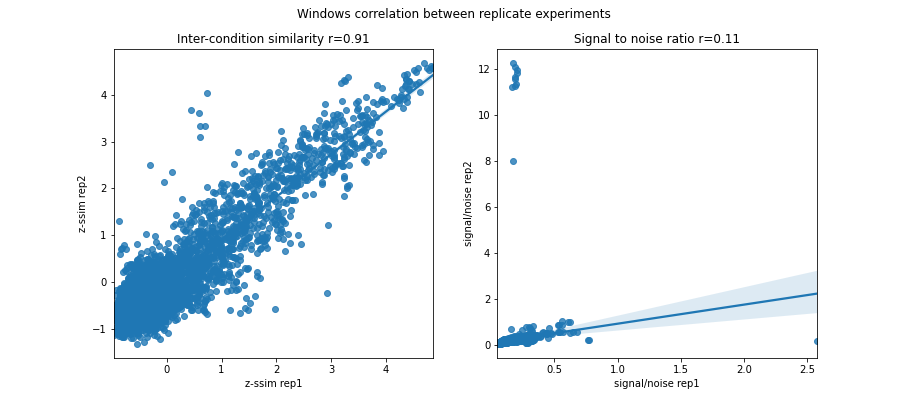

Text(0, 0.5, 'signal/noise rep2')

In [289]:
%matplotlib notebook
import scipy.stats as ss
def prepro_chess(df, wins):
    df['start'] = wins.iloc[:, 1]
    df['abs_start'] = df['start'].diff().fillna(0)
    chromstart = df.abs_start < 0
    df.abs_start[chromstart] = 1
    df.abs_start = df.abs_start.cumsum()
    
    return df

### Chess change detection
chess_r1 = pd.read_csv(f'chess/rep1/{WIN}_win_{STEP}_step_legio_results.tsv', sep='\t')
chess_r2 = pd.read_csv(f'chess/rep2/{WIN}_win_{STEP}_step_legio_results.tsv', sep='\t')
chess_r1 = prepro_chess(chess_r1, wins)
chess_r2 = prepro_chess(chess_r2, wins)

fig, ax = plt.subplots(1, 2)

sns.regplot(x=chess_r1.z_ssim, y=chess_r2.z_ssim, ax=ax[0])
sns.regplot(x=chess_r1.SN, y=chess_r2.SN, ax=ax[1])

plt.suptitle('Windows correlation between replicate experiments')
na_filter = ~np.isnan(chess_r1.z_ssim) & ~np.isnan(chess_r2.z_ssim)
ax[0].set_title(
    'Inter-condition similarity '
    f'r={ss.pearsonr(chess_r1.z_ssim[na_filter], chess_r2.z_ssim[na_filter])[0]:.2f}'
)
ax[1].set_title(
    'Signal to noise ratio '
        f'r={ss.pearsonr(chess_r1.SN[na_filter], chess_r2.SN[na_filter])[0]:.2f}'
)
ax[0].set_xlabel('z-ssim rep1'); ax[0].set_ylabel('z-ssim rep2')
ax[1].set_xlabel('signal/noise rep1'); ax[1].set_ylabel('signal/noise rep2')

If we plot window similarity along the genome for both replicates and highlight windows with a good signal/noise and low similarity for each replicate separately, we see the set of 'candidate' windows differ.
Note I had to lower the SN threshold to include noisier windows in replicate 1...

<IPython.core.display.Javascript object>


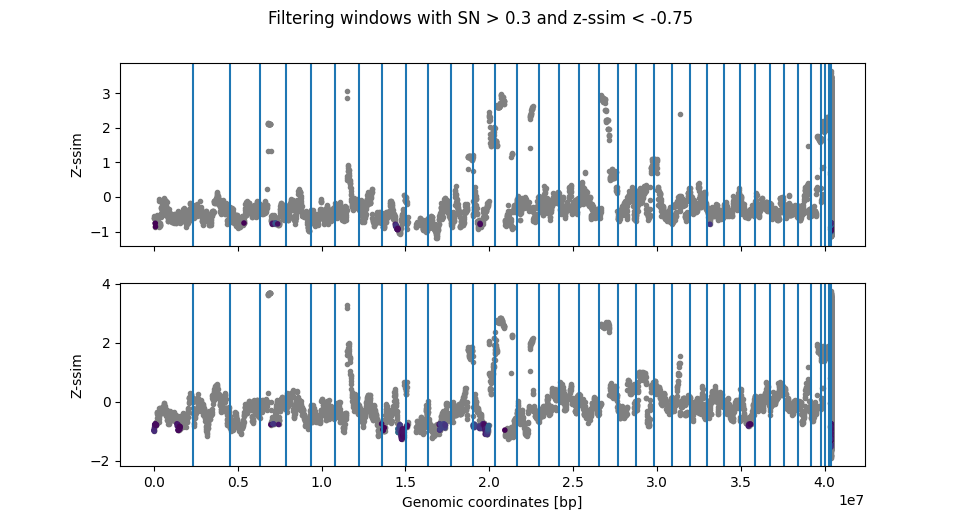

In [83]:
%matplotlib notebook
SN_THRESH = 0.3
ZSSIM_THRESH = -0.75

fig, ax = plt.subplots(2, 1, sharex=True)
for df, a in zip([chess_r1, chess_r2], ax):
    hits = (df.SN > SN_THRESH) & (df.z_ssim < ZSSIM_THRESH)
    a.scatter(df.abs_start, df.z_ssim, c='gray', marker='.')
    a.scatter(df.abs_start[hits], df.z_ssim[hits], c=df.SN[hits], marker='.')
    for v in chromstart.values:
        a.axvline(v)
    a.set_ylabel("Z-ssim")
ax[1].set_xlabel("Genomic coordinates [bp]")
plt.suptitle(f"Filtering windows with SN > {SN_THRESH} and z-ssim < {ZSSIM_THRESH}")
wins.loc[hits, :].to_csv(f'chess/{WIN}_win_{STEP}_step_filtered.bed', header=None, index=False, sep='\t')

Let's isolate the set of candidate windows common to both replicates:

In [84]:
na_filter = ~np.isnan(chess_r1.z_ssim) & ~np.isnan(chess_r2.z_ssim)
hits_r1 = na_filter & (chess_r1.SN > SN_THRESH) & (chess_r1.z_ssim < ZSSIM_THRESH)
hits_r2 = na_filter &(chess_r2.SN > SN_THRESH) & (chess_r2.z_ssim < ZSSIM_THRESH)

In [85]:
print(
    'Replicate 1 has fewer hits and '
    f'{100*(hits_r1 & hits_r2).sum() / (hits_r1).sum():.2f}% '
    'of them are present in replicate 2. There is a total of '
    f'{(hits_r1 & hits_r2).sum()} common windows.'
)

Replicate 1 has fewer hits and 39.62% of them are present in replicate 2. There is a total of 103 common windows.


In [86]:
wins.loc[hits_r1 & hits_r2, :].to_csv(f'chess/{WIN}_win_{STEP}_step_filtered_inter_rep.bed', header=None, index=False, sep='\t')

Results were not very conclusive with the intersect of replicate candidate windows. Instead, I'll run feature extraction on windows previously selected on the merge.

In [87]:
%%bash -s "$WIN" "$STEP"
mkdir -p chess/rep1/features
mkdir -p chess/rep2/features
chess extract "chess/$1_win_$2_step_filtered.bed" \
              data/output/cool/AT419.cool \
              data/output/cool/AT420.cool \
              chess/rep1/features
              
chess extract "chess/$1_win_$2_step_filtered.bed" \
              data/output/cool/AT421.cool \
              data/output/cool/AT418.cool \
              chess/rep2/features
#chess crosscorrelate chess/features/lost_features.tsv \
#                     chess/100kb_win_2kb_step_filtered_inter_rep.bed \
#                     ./chess/features

2021-03-11 18:18:33,072 INFO Running '/opt/anaconda3/envs/smk/bin/chess extract chess/100000_win_2000_step_filtered.bed data/output/cool/AT419.cool data/output/cool/AT420.cool chess/rep1/features'
2021-03-11 18:18:33,803 INFO CHESS version: 0.3.6
2021-03-11 18:18:33,803 INFO FAN-C version: 0.9.14
2021-03-11 18:18:33,804 INFO Loading reference contact data
2021-03-11 18:19:01,640 INFO Loading region pairs
2021-03-11 18:19:01,641 INFO Applying image filtering to identify specific structures
Traceback (most recent call last):
  File "/opt/anaconda3/envs/smk/bin/chess", line 585, in <module>
    Chess()
  File "/opt/anaconda3/envs/smk/bin/chess", line 75, in __init__
    getattr(self, args.command)([sys.argv[0]] + sys.argv[option_ix:])
  File "/opt/anaconda3/envs/smk/bin/chess", line 567, in extract
    args.closing_square)
  File "/opt/anaconda3/envs/smk/lib/python3.7/site-packages/chess/get_structures.py", line 154, in extract_structures
    filter2 = filters.threshold_otsu(filter_negati

Both replicates seem to have the feature at scaffold 13 that was detected on the merge, but the feature from scaffold 7 was lost.


In [88]:
lost_r1 = pd.read_csv(
    'chess/rep1/features/lost_features.tsv',
    usecols=range(6),
    names=['win', 'ft', 'xmin', 'xmax', 'ymin', 'ymax']
)
lost_r1

,win,ft,xmin,xmax,ymin,ymax
0,3,0,42,44,24,27
1,143,1,32,35,24,27
2,145,2,22,25,24,27
3,146,3,19,20,24,27
4,147,4,12,15,24,27
5,148,5,8,10,24,27
6,149,6,0,4,25,26
7,151,7,11,14,23,28
8,154,8,7,8,21,30
9,155,9,44,45,24,27


In [54]:
gained_r1 = pd.read_csv(
    'chess/rep1/features/gained_features.tsv',
    usecols=range(6),
    names=['win', 'ft', 'xmin', 'xmax', 'ymin', 'ymax']
)
gained_r1

,win,ft,xmin,xmax,ymin,ymax
0,7,0,2,4,23,28
1,7,1,45,48,23,28
2,8,2,37,40,24,27
3,11,3,19,28,23,28
4,13,4,9,18,23,28
5,14,5,3,12,22,29
6,14,6,47,48,23,28
7,15,7,45,48,23,28
8,144,8,22,23,24,27
9,146,9,12,13,24,27


In [55]:


# Load features
lost_r2 = pd.read_csv(
    'chess/rep2/features/lost_features.tsv',
    usecols=range(6),
    names=['win', 'ft', 'xmin', 'xmax', 'ymin', 'ymax']
)
lost_r2

,win,ft,xmin,xmax,ymin,ymax
0,1,0,34,36,21,30
1,2,1,30,31,21,30
2,3,2,24,26,21,30
3,4,3,20,21,21,30
4,5,4,14,16,21,30
5,15,5,40,41,22,29
6,139,6,25,28,23,28
7,143,7,4,8,21,30
8,144,8,3,4,22,29
9,149,9,40,43,20,31


In [56]:
gained_r2 = pd.read_csv(
    'chess/rep2/features/gained_features.tsv',
    usecols=range(6),
    names=['win', 'ft', 'xmin', 'xmax', 'ymin', 'ymax']
)

In [57]:
gained_ft

NameError: name 'gained_ft' is not defined

In [58]:
wins.loc[wins.iloc[:, 6] == 10217, :]

,0,1,2,3,4,5,6,7,8,9


Only the feature from the region on scaffold 13 is conserved in both replicates, which makes it the most interesting to look at. Let's have a look at gene expression change in this region.

### Differential expression

Now that we have identified a group of genes with 3D changes, let's check whether their expression also changes during infection.

In [61]:
diff_expr = pd.read_csv('data/output/diff_expr/de_genes.tsv', sep='\t')
diff_expr

,accession,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,c3
0,ACA1_000210,474.681614,-0.673862,0.203958,-3.303921,0.000953,0.002987,NaN
1,ACA1_000220,109.068615,-0.394487,0.181319,-2.175652,0.029581,0.057943,FUN_011364
2,ACA1_000330,344.708090,0.454608,0.111475,4.078131,0.000045,0.000202,NaN
3,ACA1_000530,312.524574,-0.653631,0.179799,-3.635355,0.000278,0.001005,FUN_001668
4,ACA1_000540,312.324909,-0.224862,0.143575,-1.566162,0.117311,0.185845,FUN_001669
...,...,...,...,...,...,...,...,...
16061,ACA1_400590,499.255288,0.220975,0.078907,2.800463,0.005103,0.012838,FUN_004281
16062,ACA1_400800,275.775852,0.321421,0.150552,2.134951,0.032765,0.063347,FUN_004281
16063,ACA1_400910,603.799901,0.331212,0.136062,2.434277,0.014922,0.032327,FUN_004281
16064,ACA1_401020,343.682286,0.428377,0.169451,2.528024,0.011471,0.025754,FUN_004282


In [62]:
# Gather list of gene accessions in any of the three regions reported by Chess
chess_acc = np.unique(query_ucsc_df(range_2, liftover)['accession'])

Visualizing the expression of genes from the region (red) compared to the rest of the genome (grey). Genes which pass differential expression threshold are in clear, while others are blurred.

<IPython.core.display.Javascript object>


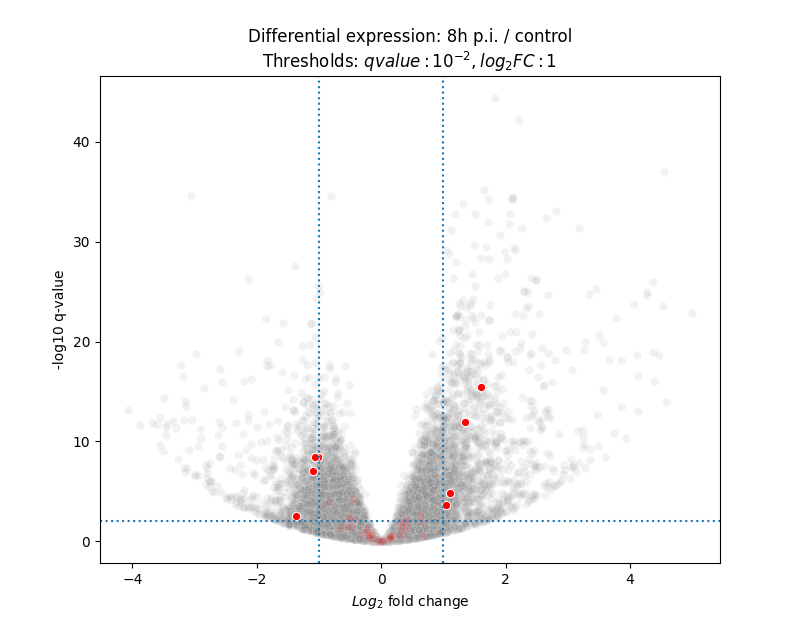

Text(0.5, 1.0, 'Differential expression: 8h p.i. / control\nThresholds: $qvalue: 10^{-2}, log_2FC: 1$')

In [63]:
%matplotlib notebook
FC = 1 # Threshold for log2 fold change
PLOG = 2 # Threshold for -log10(pvalue)
diff_expr['logpval'] = -np.log10(diff_expr.padj)
chess_genes = diff_expr.loc[diff_expr.accession.isin(chess_acc), :]
candidates = chess_genes.loc[(diff_expr.logpval > PLOG) & (diff_expr.log2FoldChange.abs() > FC), :]
sns.scatterplot(data=diff_expr, x='log2FoldChange', y='logpval', color='grey', alpha=0.1)
sns.scatterplot(data=chess_genes, x='log2FoldChange', y='logpval', color='red', alpha=0.1)
sns.scatterplot(data=candidates, x='log2FoldChange', y='logpval', color='red')
plt.axvline(FC, ls=':')
plt.axvline(-FC, ls=':')
plt.axhline(PLOG, ls=':')
plt.xlabel("$Log_2$ fold change")
plt.ylabel("-log10 q-value")
plt.title("Differential expression: 8h p.i. / control\nThresholds: $qvalue: 10^{-2}, log_2FC: 1$")

Here is the list of differentially expressed genes which fall in regions from CHESS:

In [143]:
candidates

,accession,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,c3,logpval
878,ACA1_036920,716.374178,-1.019513,0.161403,-6.316573,2.670000e-10,3.970000e-09,FUN_002670,8.401209
879,ACA1_036930,275.291529,1.611144,0.186655,8.631663,6.050000e-18,3.670000e-16,FUN_002670,15.435334
880,ACA1_036940,443.021634,1.099382,0.233562,4.707018,2.510000e-06,1.540000e-05,FUN_002671,4.812479
881,ACA1_036950,848.081548,1.048619,0.260581,4.024162,5.720000e-05,2.491303e-04,FUN_002671,3.603573
909,ACA1_037430,151.806899,-1.088226,0.189528,-5.741769,9.370000e-09,1.000000e-07,FUN_002690,7.000000
910,ACA1_037440,192.775783,-1.068832,0.168594,-6.339695,2.300000e-10,3.480000e-09,FUN_002690,8.458421
12854,ACA1_307910,137.671202,-1.367851,0.413129,-3.310950,9.297983e-04,2.919106e-03,FUN_002695,2.534750
12855,ACA1_307920,189.487683,1.347380,0.177745,7.580413,3.440000e-14,1.080000e-12,FUN_002694,11.966576


And corresponding annotations (excluding genes without annotations):

In [163]:
print(liftover.loc[liftover.accession.isin(candidates.accession), :].query('desc != "hypothetical protein"').drop('attr', axis=1).to_markdown())

|       | chrom       | type   |   start |     end | accession   | desc                                    |
|------:|:------------|:-------|--------:|--------:|:------------|:----------------------------------------|
| 41434 | scaffold_13 | gene   | 1311135 | 1313828 | ACA1_036920 | rhodaneselike domain containing protein |
| 41454 | scaffold_13 | gene   | 1314564 | 1316069 | ACA1_036930 | dehydrodolichyl diphosphate synthase    |
| 41476 | scaffold_13 | gene   | 1318686 | 1320655 | ACA1_036950 | R3H domain containing protein           |


In [1]:
liftover.loc[liftover.accession.isin(candidates.accession), :].query('desc != "hypothetical protein"').drop('attr', axis=1)

NameError: name 'liftover' is not defined